<a href="https://colab.research.google.com/github/JingyuanWu17/DL/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

###Data Preprocessing

In [ ]:
!pip install mtcnn

In [ ]:
import numpy as np
from os import listdir
from PIL import Image
from mtcnn.mtcnn import MTCNN


def load_image(filename):
    image = Image.open(filename)
    image = image.convert('RGB')
    img_pixels = np.asarray(image)
    return img_pixels


# extract face from loaded image by using MTCNN
def extract_face(model, img_pixels, size=(80, 80)):
    face = model.detect_faces(img_pixels)
    if len(face) == 0: return None

    x1, y1, width, height = face[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face_pixels = img_pixels[y1:y2, x1:x2]

    face_img_resize = Image.fromarray(face_pixels).resize(size)
    return np.asarray(face_img_resize)


# load images and extract faces from directory
def load_faces(directory, n_faces):
    model = MTCNN()
    faces = []
    for filename in listdir(directory):
        # load image
        img_pixels = load_image(directory + filename)

        # extract face
        face = extract_face(model, img_pixels)
        if face is None: continue

        faces.append(face)

        if len(faces) >= n_faces: break

    return np.asarray(faces)


directory = '/content/drive/MyDrive/GAN/samples/'
faces = load_faces(directory, 5)
print('faces shape: ', faces.shape)

# save file
np.savez_compressed('preprocessed_faces.npz', faces)

###Models

####Discriminator

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.optimizers import Adam


def discriminator_model(in_shape=(80, 80, 3)):
    model = Sequential()

    # normal, 80 x 80
    model.add(Conv2D(128, (5, 5), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    # downsample to 40 x 40
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # downsample to 20 x 20
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # downsample to 10 x 10
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # downsample to 5 x 5
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model


discriminator = discriminator_model()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 80, 80, 128)       9728      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 80, 80, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 40, 40, 128)       409728    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 40, 40, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 20, 20, 128)       409728    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 128)       4

####Generator

In [4]:
def generator_model(latent_dim=100):
    model = Sequential()

    model.add(Dense(128 * 5 * 5, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((5, 5, 128)))

    # upsample to 10 x 10
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # upsample to 20 x 20
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # upsample to 40 x 40
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # upsample to 80 x 80
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(3, (5, 5), activation='tanh', padding='same'))

    return model


generator = generator_model()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 3200)              323200    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 3200)              0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 10, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 20, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 20, 20, 128)      

####GAN

In [5]:
def GAN_model(generator, discriminator):
    model = Sequential()

    # set discriminator's weights as non-trainable
    discriminator.trainable = False

    # add generator
    model.add(generator)

    # add discriminator
    model.add(discriminator)

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)

    return model


GAN = GAN_model(generator, discriminator)
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 80, 80, 3)         1381891   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 1651841   
Total params: 3,033,732
Trainable params: 1,381,891
Non-trainable params: 1,651,841
_________________________________________________________________


###Train

####Helper functions

In [6]:
import matplotlib.pyplot as plt


def load_prepocessed_faces():
    data = np.load('preprocessed_faces.npz')
    X = data['arr_0'].astype('float32')
    X = (X - 127.5) / 127.5
    return X


def generate_latent_points(latent_dim, n_samples):
    X = np.random.randn(latent_dim * n_samples)
    X = X.reshape(n_samples, latent_dim)
    return X


# randomly select 'real' samples from dataset, and create 'real' class labels
def generate_real_training_set(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y


# use generator to generate fake samples, and create 'fake' class labels
def generate_fake_training_set(g_model, latent_dim, n_samples):
    X = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(X)
    y = np.zeros((n_samples, 1))
    return X, y



####Training

In [11]:
def train(generator, discriminator, GAN, dataset, latent_dim=100, n_epochs=100, batch_size=128):
    batch_per_epoch = int(dataset.shape[0] / batch_size)
    half_batch = int(batch_size / 2)

    d_losses_real = []
    d_losses_fake = []
    g_losses = []

    for i in range(n_epochs):
        d_losses_real_tmp = []
        d_losses_fake_tmp = []
        g_losses_tmp = []

        for j in range(batch_per_epoch):
            # get 'real' training set (half batch size)
            X_real, y_real = generate_real_training_set(dataset, half_batch)

            # update discriminator's weights via 'real' training set
            d_loss_real, _ = discriminator.train_on_batch(X_real, y_real)
            d_losses_real_tmp.append(d_loss_real)

            # get 'fake' training set (half batch size)
            X_fake, y_fake = generate_fake_training_set(generator, latent_dim, half_batch)

            # update discriminator's weights via 'fake' training set
            d_loss_fake, _ = discriminator.train_on_batch(X_fake, y_fake)
            d_losses_fake_tmp.append(d_loss_fake)

            # prepare latent points (batch size) as input for the GAN model
            X_gan = generate_latent_points(latent_dim, batch_size)

            # create inverted labels (batch size) for the GAN model
            y_gan = np.ones((batch_size, 1))

            # update generator's weight via discriminator's error
            g_loss = GAN.train_on_batch(X_gan, y_gan)
            g_losses_tmp.append(g_loss)

            print('>>>%d, %d/%d, d_loss_real=%.3f, d_loss_fake=%.3f g_loss=%.3f' %
                  (i + 1, j + 1, batch_per_epoch, d_loss_real, d_loss_fake, g_loss))

        d_losses_real.append(np.average(d_losses_real_tmp))
        d_losses_fake.append(np.average(d_losses_fake_tmp))
        g_losses.append(np.average(g_losses_tmp))

        # generate 'fake' images and save plot for every ten epochs
        if (i + 1) % 10 == 0:
            X_fake, _ = generate_fake_training_set(generator, latent_dim, 100)
            X_fake = (X_fake + 1) / 2.0
            plt.figure()
            for i in range(100):
                plt.subplot(10, 10, i + 1)
                plt.axis('off')
                plt.imshow(X_fake[i], cmap='gray_r')
            plt.show()

    return d_losses_real, d_losses_fake, g_losses

>>>1, 1/156, d_loss_real=0.700, d_loss_fake=0.695 g_loss=0.692
>>>1, 2/156, d_loss_real=0.565, d_loss_fake=0.698 g_loss=0.689
>>>1, 3/156, d_loss_real=0.274, d_loss_fake=0.727 g_loss=0.660
>>>1, 4/156, d_loss_real=0.015, d_loss_fake=0.796 g_loss=0.640
>>>1, 5/156, d_loss_real=0.007, d_loss_fake=0.816 g_loss=0.650
>>>1, 6/156, d_loss_real=0.037, d_loss_fake=0.800 g_loss=0.669
>>>1, 7/156, d_loss_real=0.050, d_loss_fake=0.772 g_loss=0.695
>>>1, 8/156, d_loss_real=0.036, d_loss_fake=0.701 g_loss=0.728
>>>1, 9/156, d_loss_real=0.009, d_loss_fake=0.655 g_loss=0.827
>>>1, 10/156, d_loss_real=0.017, d_loss_fake=0.599 g_loss=1.033
>>>1, 11/156, d_loss_real=0.026, d_loss_fake=0.537 g_loss=1.154
>>>1, 12/156, d_loss_real=0.000, d_loss_fake=0.432 g_loss=1.569
>>>1, 13/156, d_loss_real=0.007, d_loss_fake=0.320 g_loss=1.915
>>>1, 14/156, d_loss_real=0.000, d_loss_fake=0.161 g_loss=2.914
>>>1, 15/156, d_loss_real=0.554, d_loss_fake=0.151 g_loss=1.977
>>>1, 16/156, d_loss_real=0.000, d_loss_fake=0.14

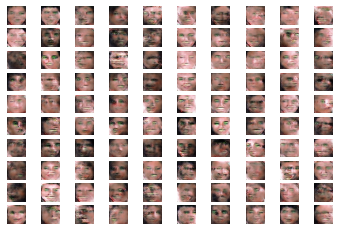

>>>11, 1/156, d_loss_real=0.272, d_loss_fake=0.215 g_loss=4.454
>>>11, 2/156, d_loss_real=0.182, d_loss_fake=0.176 g_loss=4.544
>>>11, 3/156, d_loss_real=0.177, d_loss_fake=0.358 g_loss=5.826
>>>11, 4/156, d_loss_real=0.444, d_loss_fake=0.298 g_loss=5.290
>>>11, 5/156, d_loss_real=0.181, d_loss_fake=0.135 g_loss=4.934
>>>11, 6/156, d_loss_real=0.206, d_loss_fake=0.477 g_loss=7.474
>>>11, 7/156, d_loss_real=1.429, d_loss_fake=0.335 g_loss=3.164
>>>11, 8/156, d_loss_real=0.118, d_loss_fake=0.203 g_loss=3.897
>>>11, 9/156, d_loss_real=0.322, d_loss_fake=0.075 g_loss=4.048
>>>11, 10/156, d_loss_real=0.093, d_loss_fake=0.105 g_loss=3.990
>>>11, 11/156, d_loss_real=0.086, d_loss_fake=0.118 g_loss=4.222
>>>11, 12/156, d_loss_real=0.060, d_loss_fake=0.115 g_loss=4.790
>>>11, 13/156, d_loss_real=0.182, d_loss_fake=0.125 g_loss=4.208
>>>11, 14/156, d_loss_real=0.165, d_loss_fake=0.244 g_loss=5.353
>>>11, 15/156, d_loss_real=0.321, d_loss_fake=0.052 g_loss=3.806
>>>11, 16/156, d_loss_real=0.165, 

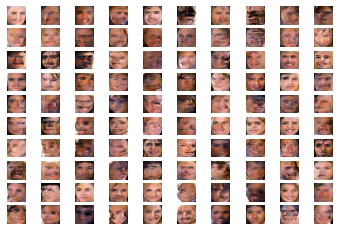

>>>21, 1/156, d_loss_real=0.194, d_loss_fake=0.238 g_loss=3.787
>>>21, 2/156, d_loss_real=0.180, d_loss_fake=0.173 g_loss=3.714
>>>21, 3/156, d_loss_real=0.296, d_loss_fake=0.158 g_loss=3.181
>>>21, 4/156, d_loss_real=0.147, d_loss_fake=0.290 g_loss=3.669
>>>21, 5/156, d_loss_real=0.413, d_loss_fake=0.492 g_loss=3.413
>>>21, 6/156, d_loss_real=0.365, d_loss_fake=0.242 g_loss=3.351
>>>21, 7/156, d_loss_real=0.237, d_loss_fake=0.207 g_loss=3.116
>>>21, 8/156, d_loss_real=0.147, d_loss_fake=0.137 g_loss=2.944
>>>21, 9/156, d_loss_real=0.248, d_loss_fake=0.352 g_loss=3.152
>>>21, 10/156, d_loss_real=0.264, d_loss_fake=0.157 g_loss=3.262
>>>21, 11/156, d_loss_real=0.259, d_loss_fake=0.426 g_loss=3.689
>>>21, 12/156, d_loss_real=0.470, d_loss_fake=0.196 g_loss=3.061
>>>21, 13/156, d_loss_real=0.245, d_loss_fake=0.559 g_loss=4.051
>>>21, 14/156, d_loss_real=0.434, d_loss_fake=0.177 g_loss=3.319
>>>21, 15/156, d_loss_real=0.264, d_loss_fake=0.293 g_loss=3.166
>>>21, 16/156, d_loss_real=0.214, 

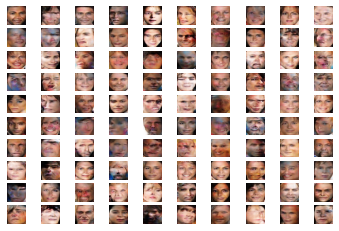

>>>31, 1/156, d_loss_real=0.324, d_loss_fake=0.234 g_loss=2.735
>>>31, 2/156, d_loss_real=0.402, d_loss_fake=0.293 g_loss=2.743
>>>31, 3/156, d_loss_real=0.337, d_loss_fake=0.319 g_loss=2.931
>>>31, 4/156, d_loss_real=0.203, d_loss_fake=0.242 g_loss=3.096
>>>31, 5/156, d_loss_real=0.291, d_loss_fake=0.276 g_loss=2.868
>>>31, 6/156, d_loss_real=0.320, d_loss_fake=0.344 g_loss=2.749
>>>31, 7/156, d_loss_real=0.354, d_loss_fake=0.413 g_loss=3.140
>>>31, 8/156, d_loss_real=0.562, d_loss_fake=0.433 g_loss=2.854
>>>31, 9/156, d_loss_real=0.348, d_loss_fake=0.217 g_loss=2.973
>>>31, 10/156, d_loss_real=0.277, d_loss_fake=0.392 g_loss=3.175
>>>31, 11/156, d_loss_real=0.470, d_loss_fake=0.374 g_loss=3.094
>>>31, 12/156, d_loss_real=0.326, d_loss_fake=0.293 g_loss=3.205
>>>31, 13/156, d_loss_real=0.392, d_loss_fake=0.353 g_loss=3.069
>>>31, 14/156, d_loss_real=0.372, d_loss_fake=0.278 g_loss=3.010
>>>31, 15/156, d_loss_real=0.498, d_loss_fake=0.597 g_loss=3.202
>>>31, 16/156, d_loss_real=0.579, 

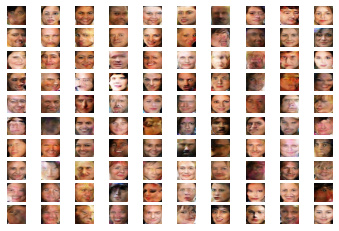

>>>41, 1/156, d_loss_real=0.648, d_loss_fake=0.573 g_loss=2.807
>>>41, 2/156, d_loss_real=0.583, d_loss_fake=0.346 g_loss=2.412
>>>41, 3/156, d_loss_real=0.498, d_loss_fake=0.395 g_loss=2.556
>>>41, 4/156, d_loss_real=0.478, d_loss_fake=0.308 g_loss=2.462
>>>41, 5/156, d_loss_real=0.278, d_loss_fake=0.500 g_loss=2.908
>>>41, 6/156, d_loss_real=0.510, d_loss_fake=0.287 g_loss=2.844
>>>41, 7/156, d_loss_real=0.426, d_loss_fake=0.548 g_loss=2.692
>>>41, 8/156, d_loss_real=0.446, d_loss_fake=0.297 g_loss=2.767
>>>41, 9/156, d_loss_real=0.559, d_loss_fake=0.427 g_loss=2.482
>>>41, 10/156, d_loss_real=0.445, d_loss_fake=0.479 g_loss=2.755
>>>41, 11/156, d_loss_real=0.424, d_loss_fake=0.351 g_loss=2.720
>>>41, 12/156, d_loss_real=0.301, d_loss_fake=0.397 g_loss=3.007
>>>41, 13/156, d_loss_real=0.470, d_loss_fake=0.340 g_loss=2.655
>>>41, 14/156, d_loss_real=0.540, d_loss_fake=0.492 g_loss=2.394
>>>41, 15/156, d_loss_real=0.289, d_loss_fake=0.353 g_loss=2.702
>>>41, 16/156, d_loss_real=0.452, 

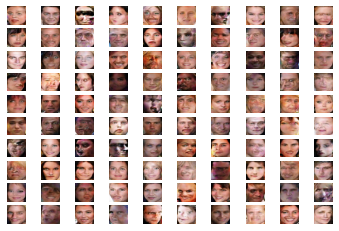

>>>51, 1/156, d_loss_real=0.267, d_loss_fake=0.493 g_loss=2.407
>>>51, 2/156, d_loss_real=0.525, d_loss_fake=0.565 g_loss=2.338
>>>51, 3/156, d_loss_real=0.525, d_loss_fake=0.438 g_loss=2.417
>>>51, 4/156, d_loss_real=0.450, d_loss_fake=0.438 g_loss=2.524
>>>51, 5/156, d_loss_real=0.502, d_loss_fake=0.347 g_loss=2.281
>>>51, 6/156, d_loss_real=0.376, d_loss_fake=0.456 g_loss=2.557
>>>51, 7/156, d_loss_real=0.487, d_loss_fake=0.214 g_loss=2.435
>>>51, 8/156, d_loss_real=0.311, d_loss_fake=0.314 g_loss=2.409
>>>51, 9/156, d_loss_real=0.339, d_loss_fake=0.364 g_loss=2.649
>>>51, 10/156, d_loss_real=0.336, d_loss_fake=0.419 g_loss=2.684
>>>51, 11/156, d_loss_real=0.348, d_loss_fake=0.375 g_loss=2.671
>>>51, 12/156, d_loss_real=0.375, d_loss_fake=0.319 g_loss=2.680
>>>51, 13/156, d_loss_real=0.331, d_loss_fake=0.361 g_loss=2.520
>>>51, 14/156, d_loss_real=0.396, d_loss_fake=0.481 g_loss=2.516
>>>51, 15/156, d_loss_real=0.377, d_loss_fake=0.329 g_loss=2.619
>>>51, 16/156, d_loss_real=0.539, 

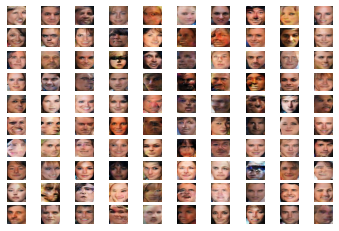

>>>61, 1/156, d_loss_real=0.406, d_loss_fake=0.352 g_loss=2.617
>>>61, 2/156, d_loss_real=0.398, d_loss_fake=0.361 g_loss=2.447
>>>61, 3/156, d_loss_real=0.411, d_loss_fake=0.405 g_loss=2.387
>>>61, 4/156, d_loss_real=0.343, d_loss_fake=0.365 g_loss=2.852
>>>61, 5/156, d_loss_real=0.545, d_loss_fake=0.406 g_loss=2.500
>>>61, 6/156, d_loss_real=0.352, d_loss_fake=0.436 g_loss=2.621
>>>61, 7/156, d_loss_real=0.509, d_loss_fake=0.606 g_loss=3.048
>>>61, 8/156, d_loss_real=0.516, d_loss_fake=0.328 g_loss=2.640
>>>61, 9/156, d_loss_real=0.470, d_loss_fake=0.316 g_loss=2.198
>>>61, 10/156, d_loss_real=0.426, d_loss_fake=0.465 g_loss=2.483
>>>61, 11/156, d_loss_real=0.358, d_loss_fake=0.264 g_loss=2.412
>>>61, 12/156, d_loss_real=0.475, d_loss_fake=0.567 g_loss=2.311
>>>61, 13/156, d_loss_real=0.427, d_loss_fake=0.310 g_loss=2.056
>>>61, 14/156, d_loss_real=0.348, d_loss_fake=0.597 g_loss=2.533
>>>61, 15/156, d_loss_real=0.528, d_loss_fake=0.449 g_loss=2.646
>>>61, 16/156, d_loss_real=0.519, 

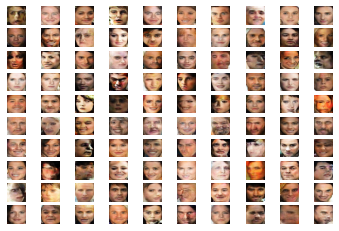

>>>71, 1/156, d_loss_real=0.401, d_loss_fake=0.452 g_loss=2.658
>>>71, 2/156, d_loss_real=0.475, d_loss_fake=0.495 g_loss=2.524
>>>71, 3/156, d_loss_real=0.371, d_loss_fake=0.322 g_loss=2.538
>>>71, 4/156, d_loss_real=0.445, d_loss_fake=0.391 g_loss=2.613
>>>71, 5/156, d_loss_real=0.395, d_loss_fake=0.321 g_loss=2.365
>>>71, 6/156, d_loss_real=0.388, d_loss_fake=0.387 g_loss=2.506
>>>71, 7/156, d_loss_real=0.448, d_loss_fake=0.779 g_loss=3.239
>>>71, 8/156, d_loss_real=0.564, d_loss_fake=0.234 g_loss=2.984
>>>71, 9/156, d_loss_real=0.493, d_loss_fake=0.224 g_loss=2.168
>>>71, 10/156, d_loss_real=0.213, d_loss_fake=0.390 g_loss=2.597
>>>71, 11/156, d_loss_real=0.380, d_loss_fake=0.320 g_loss=2.624
>>>71, 12/156, d_loss_real=0.311, d_loss_fake=0.308 g_loss=2.559
>>>71, 13/156, d_loss_real=0.350, d_loss_fake=0.312 g_loss=2.605
>>>71, 14/156, d_loss_real=0.343, d_loss_fake=0.288 g_loss=2.529
>>>71, 15/156, d_loss_real=0.413, d_loss_fake=0.310 g_loss=2.519
>>>71, 16/156, d_loss_real=0.278, 

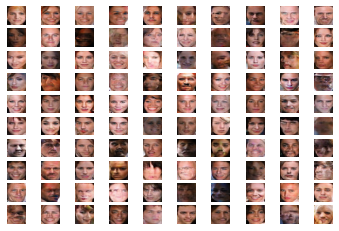

>>>81, 1/156, d_loss_real=0.277, d_loss_fake=0.343 g_loss=3.138
>>>81, 2/156, d_loss_real=0.282, d_loss_fake=0.464 g_loss=3.580
>>>81, 3/156, d_loss_real=0.487, d_loss_fake=0.313 g_loss=3.092
>>>81, 4/156, d_loss_real=0.281, d_loss_fake=0.260 g_loss=2.932
>>>81, 5/156, d_loss_real=0.263, d_loss_fake=0.220 g_loss=2.968
>>>81, 6/156, d_loss_real=0.169, d_loss_fake=0.424 g_loss=3.977
>>>81, 7/156, d_loss_real=0.612, d_loss_fake=0.127 g_loss=3.036
>>>81, 8/156, d_loss_real=0.270, d_loss_fake=0.423 g_loss=3.150
>>>81, 9/156, d_loss_real=0.264, d_loss_fake=0.158 g_loss=3.083
>>>81, 10/156, d_loss_real=0.263, d_loss_fake=0.262 g_loss=2.971
>>>81, 11/156, d_loss_real=0.271, d_loss_fake=0.375 g_loss=3.170
>>>81, 12/156, d_loss_real=0.299, d_loss_fake=0.265 g_loss=3.225
>>>81, 13/156, d_loss_real=0.453, d_loss_fake=0.186 g_loss=2.752
>>>81, 14/156, d_loss_real=0.186, d_loss_fake=0.325 g_loss=3.287
>>>81, 15/156, d_loss_real=0.210, d_loss_fake=0.188 g_loss=3.225
>>>81, 16/156, d_loss_real=0.326, 

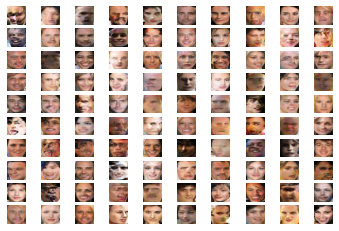

>>>91, 1/156, d_loss_real=0.557, d_loss_fake=0.530 g_loss=1.688
>>>91, 2/156, d_loss_real=0.290, d_loss_fake=0.378 g_loss=2.067
>>>91, 3/156, d_loss_real=0.437, d_loss_fake=0.378 g_loss=1.899
>>>91, 4/156, d_loss_real=0.522, d_loss_fake=0.679 g_loss=2.218
>>>91, 5/156, d_loss_real=0.594, d_loss_fake=0.382 g_loss=2.040
>>>91, 6/156, d_loss_real=0.665, d_loss_fake=0.458 g_loss=1.970
>>>91, 7/156, d_loss_real=0.420, d_loss_fake=0.464 g_loss=1.899
>>>91, 8/156, d_loss_real=0.287, d_loss_fake=0.337 g_loss=2.282
>>>91, 9/156, d_loss_real=0.439, d_loss_fake=0.555 g_loss=2.434
>>>91, 10/156, d_loss_real=0.618, d_loss_fake=0.359 g_loss=2.280
>>>91, 11/156, d_loss_real=0.672, d_loss_fake=0.480 g_loss=1.984
>>>91, 12/156, d_loss_real=0.357, d_loss_fake=0.381 g_loss=2.134
>>>91, 13/156, d_loss_real=0.350, d_loss_fake=0.499 g_loss=2.113
>>>91, 14/156, d_loss_real=0.525, d_loss_fake=0.317 g_loss=2.106
>>>91, 15/156, d_loss_real=0.448, d_loss_fake=0.532 g_loss=1.933
>>>91, 16/156, d_loss_real=0.570, 

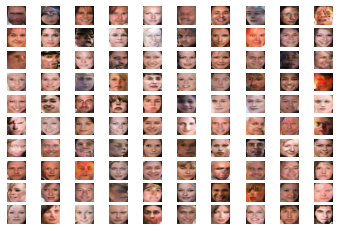

In [12]:
dataset = load_prepocessed_faces()
d_losses_real, d_losses_fake, g_losses = train(generator, discriminator, GAN, dataset)


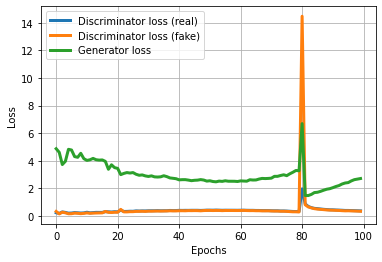

In [13]:
plt.plot(range(100),d_losses_real,'-',linewidth=3,label='Discriminator loss (real)')
plt.plot(range(100),d_losses_fake,'-',linewidth=3,label='Discriminator loss (fake)')
plt.plot(range(100),g_losses,'-',linewidth=3,label='Generator loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()